<a href="https://colab.research.google.com/github/avichhitwal/MIMO-OFDM-Communication-System-Simulation-with-Channel-Estimation/blob/main/MIMO_OFDM_Communication_System_Simulation_with_Channel_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_bits = 10000
bits_tx1 = np.random.randint(0, 2, n_bits)
bits_tx2 = np.random.randint(0, 2, n_bits)


In [3]:
def qpsk_mod(bits):
    bits = bits.reshape((-1, 2))
    mapping = {
        (0,0): 1+1j,
        (0,1): -1+1j,
        (1,0): 1-1j,
        (1,1): -1-1j
    }
    return np.array([mapping[tuple(b)] for b in bits])/np.sqrt(2)


In [4]:
def ofdm_modulate(symbols, n_subcarriers=64):
    symbols = symbols[:len(symbols)//n_subcarriers * n_subcarriers]
    symbols = symbols.reshape((-1, n_subcarriers))
    return np.fft.ifft(symbols, axis=1)


In [5]:
def simulate_mimo_channel(signal_tx1, signal_tx2):
    h11 = (np.random.randn()+1j*np.random.randn())/np.sqrt(2)
    h12 = (np.random.randn()+1j*np.random.randn())/np.sqrt(2)
    h21 = (np.random.randn()+1j*np.random.randn())/np.sqrt(2)
    h22 = (np.random.randn()+1j*np.random.randn())/np.sqrt(2)

    rx1 = h11*signal_tx1 + h12*signal_tx2
    rx2 = h21*signal_tx1 + h22*signal_tx2
    return rx1, rx2, np.array([[h11,h12],[h21,h22]])


In [6]:
def add_awgn(signal, snr_db):
    snr_linear = 10**(snr_db/10)
    power = np.mean(np.abs(signal)**2)
    noise_power = power / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))
    return signal + noise


In [7]:
def zero_forcing_receiver(rx1, rx2, H):
    H_inv = np.linalg.pinv(H)  # Moore-Penrose pseudo-inverse
    rx = np.vstack((rx1, rx2))
    estimated = H_inv @ rx
    return estimated[0,:], estimated[1,:]


In [8]:
def ofdm_demodulate(received_signal, n_subcarriers=64):
    return np.fft.fft(received_signal, axis=1)


In [9]:
def qpsk_demod(symbols):
    bits = np.zeros((symbols.shape[0],2),dtype=int)
    bits[:,0] = np.real(symbols) < 0
    bits[:,1] = np.imag(symbols) < 0
    return bits.reshape(-1)


In [10]:
def compute_ber(original_bits, received_bits):
    return np.mean(original_bits != received_bits)


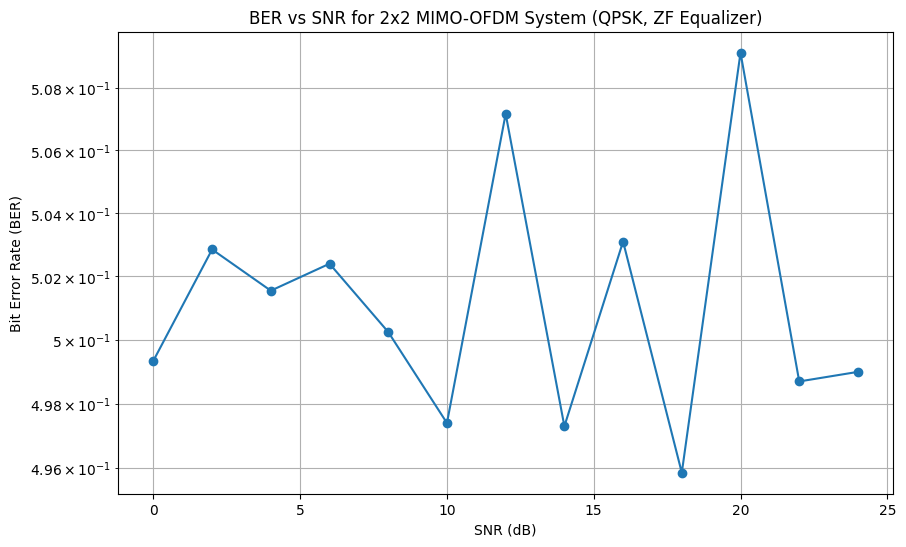

In [12]:
n_bits = 10000  # per transmitter
n_subcarriers = 64
snr_db_range = np.arange(0, 25, 2)
ber_results = []

for snr_db in snr_db_range:
    # 1. Random bits
    bits_tx1 = np.random.randint(0, 2, n_bits)
    bits_tx2 = np.random.randint(0, 2, n_bits)

    # 2. QPSK Modulation
    symbols_tx1 = qpsk_mod(bits_tx1)
    symbols_tx2 = qpsk_mod(bits_tx2)

    # 3. OFDM Modulation
    ofdm_tx1 = ofdm_modulate(symbols_tx1, n_subcarriers)
    ofdm_tx2 = ofdm_modulate(symbols_tx2, n_subcarriers)

    # 4. Simulate MIMO channel
    rx1, rx2, H = simulate_mimo_channel(ofdm_tx1.flatten(), ofdm_tx2.flatten())

    # 5. Add AWGN
    rx1_noisy = add_awgn(rx1, snr_db)
    rx2_noisy = add_awgn(rx2, snr_db)

    # 6. MIMO Equalization
    est_tx1, est_tx2 = zero_forcing_receiver(rx1_noisy, rx2_noisy, H)

    # 7. OFDM Demodulation
    est_symbols_tx1 = ofdm_demodulate(est_tx1.reshape(-1, n_subcarriers))
    est_symbols_tx2 = ofdm_demodulate(est_tx2.reshape(-1, n_subcarriers))

    # 8. QPSK Demodulation
    bits_rx1 = qpsk_demod(est_symbols_tx1.flatten())
    bits_rx2 = qpsk_demod(est_symbols_tx2.flatten())

    # 9. Compute BER
    ber1 = compute_ber(bits_tx1[:len(bits_rx1)], bits_rx1)
    ber2 = compute_ber(bits_tx2[:len(bits_rx2)], bits_rx2)
    ber_avg = (ber1 + ber2)/2
    ber_results.append(ber_avg)

# BER vs SNR
plt.figure(figsize=(10,6))
plt.semilogy(snr_db_range, ber_results, marker='o')
plt.grid(True, which='both')
plt.title('BER vs SNR for 2x2 MIMO-OFDM System (QPSK, ZF Equalizer)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.show()